In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [17, 12]
from IPython.display import Audio

In [2]:
import numpy as np
import torch
import librosa
import librosa.display as show
from scipy.signal import find_peaks

In [3]:
from rt_ddsp.synths import Harmonic, FilteredNoise

In [4]:
harmonic = Harmonic(n_samples=32000, scale_fn=None)

In [5]:
def static_sawtooth_features(fundamental_frequency, base_amplitude, n_harmonics=30, n_frames=1000, batch_size=3):
    amp = torch.zeros((batch_size, n_frames, 1), dtype=torch.float32) + base_amplitude

    harmonic_distribution = 1 / torch.arange(1, n_harmonics+1)
    harmonic_distribution.view(1, 1, n_harmonics).repeat(batch_size, n_frames, 1)
    
    f0_hz = torch.zeros((batch_size, n_frames, 1), dtype=torch.float32) + fundamental_frequency

    return {
        'amplitudes': amp,
        'harmonic_distribution': harmonic_distribution,
        'f0_hz': f0_hz
    }

In [6]:
controls = static_sawtooth_features(7000.0, 1.0)

In [7]:
signal = harmonic(**controls)
modified_controls = harmonic.get_controls(**controls)

In [8]:
Audio(signal, rate=16000, normalize=False)

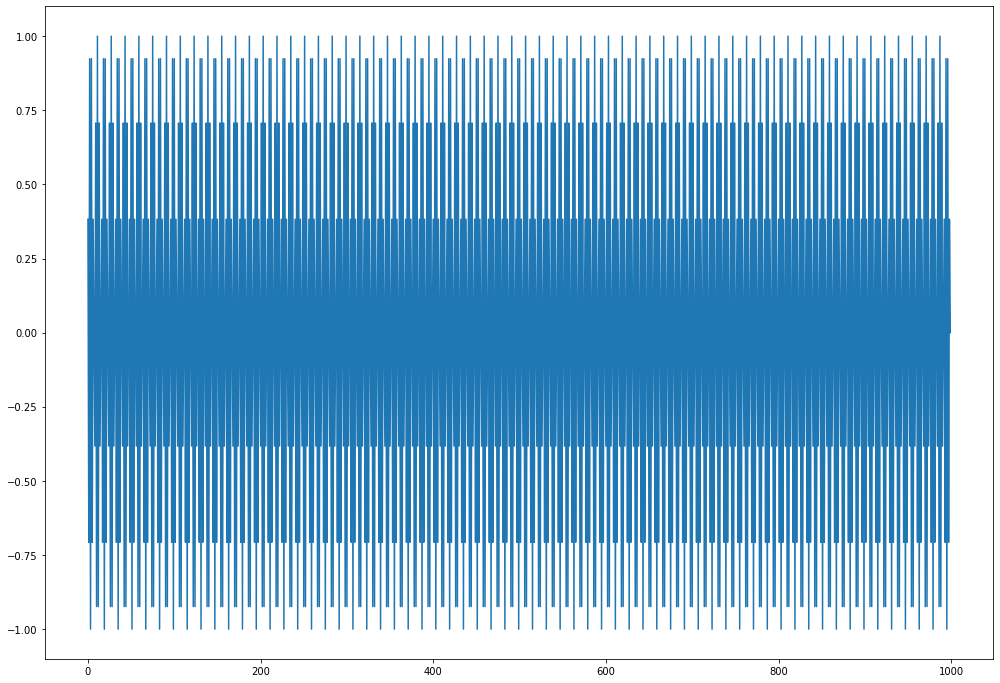

In [9]:
plt.plot(signal[0, :1000])

In [10]:
S = np.abs(np.fft.rfft(signal[0].numpy())) / 16000

In [11]:
modified_controls['amplitudes'].numpy().min()

1.0

In [12]:
peaks, _ = find_peaks(S, height=modified_controls['amplitudes'].numpy().min() * 0.95)

In [13]:
np.fft.rfftfreq(len(signal[0]), 1/16000)[peaks]

array([7000.])

In [14]:
np.arange(1, 31) * 220.

array([ 220.,  440.,  660.,  880., 1100., 1320., 1540., 1760., 1980.,
       2200., 2420., 2640., 2860., 3080., 3300., 3520., 3740., 3960.,
       4180., 4400., 4620., 4840., 5060., 5280., 5500., 5720., 5940.,
       6160., 6380., 6600.])

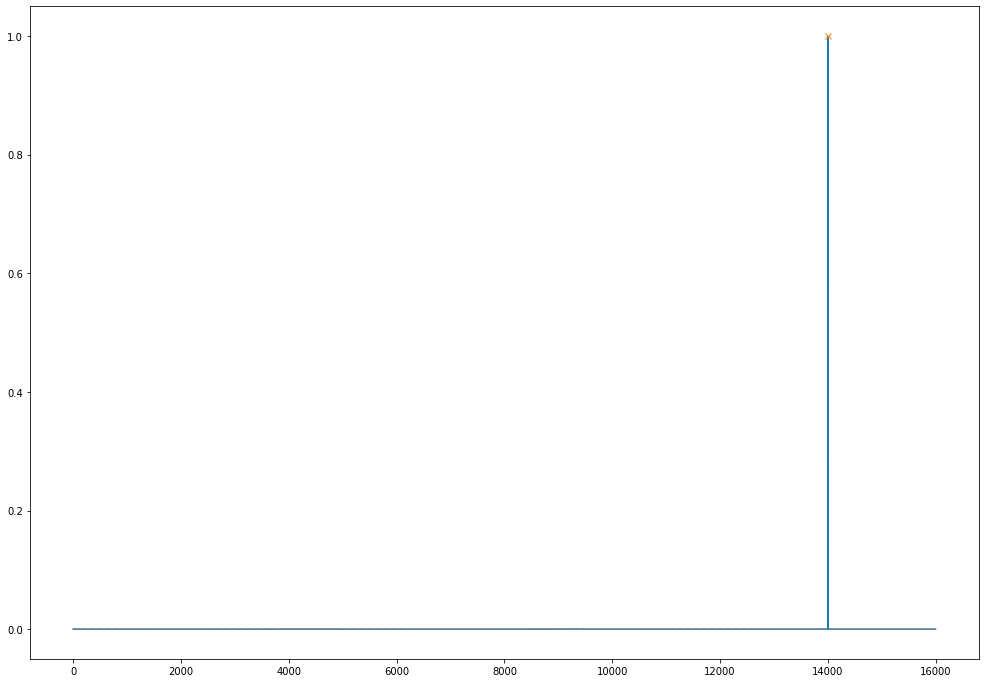

In [15]:
plt.plot(S)
plt.plot(peaks, S[peaks], "x")
plt.plot(np.zeros_like(S), "--", color="gray")
plt.show()

In [16]:
np.testing.assert_array_almost_equal(S[peaks],
                                     modified_controls['harmonic_distribution'][0, 0, 0],
                                     decimal=5)

In [17]:
S[peaks] / len(signal[0]) * 2

array([6.24998758e-05])

In [18]:
modified_controls['harmonic_distribution'][0][0] * modified_controls['amplitudes'][0][0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
S = np.stack([np.abs(np.fft.rfft(s.numpy())) for s in signal])

In [20]:
S.shape

(3, 16001)

In [21]:
np.arange(1, 5 + 1)[None, :] * np.array([220., 330.])[:, None]

array([[ 220.,  440.,  660.,  880., 1100.],
       [ 330.,  660.,  990., 1320., 1650.]])

In [22]:
from typing import Tuple, Any, Dict

In [23]:
def get_frequency_peaks(signal: torch.Tensor,
                        sample_rate: int,
                        height: float) -> Tuple[np.ndarray, np.ndarray]:
    spectrum = np.abs(np.fft.rfft(signal.numpy())) / (len(signal) / 2)
    peaks, _ = find_peaks(spectrum, height=height)
    peak_freqs = np.fft.rfftfreq(len(signal), 1 / sample_rate)[peaks]
    peak_amps = spectrum[peaks]

    plt.plot(spectrum)
    plt.plot(peaks, spectrum[peaks], "x")
    plt.plot(np.zeros_like(spectrum), "--", color="gray")
    plt.show()
    
    return peak_freqs, peak_amps


def get_batch_frequency_peaks(signal: torch.Tensor,
                              sample_rate: int,
                              height: float) -> Tuple[np.ndarray, np.ndarray]:
    peak_freqs = []
    peak_amps = []
    for s in signal:
        pf, pa = get_frequency_peaks(s, sample_rate, height)
        peak_freqs.append(pf)
        peak_amps.append(pa)

    return np.stack(peak_freqs), np.stack(peak_amps)


def static_sawtooth_features(fundamental_frequency: float,
                             base_amplitude: float,
                             n_harmonics: int = 30,
                             n_frames: int = 1000,
                             batch_size: int = 3) -> Dict[str, torch.Tensor]:
    amp = torch.zeros(batch_size, n_frames, 1) + base_amplitude

    harmonic_distribution = 1 / torch.arange(1, n_harmonics + 1)
    # harmonic_distribution = torch.ones(n_harmonics)  # impulse features
    harmonic_distribution.view(1, 1, n_harmonics).repeat(batch_size, n_frames, 1)

    f0_hz = torch.zeros(batch_size, n_frames, 1) + fundamental_frequency

    return {
        'amplitudes': amp,
        'harmonic_distribution': harmonic_distribution,
        'f0_hz': f0_hz
    }


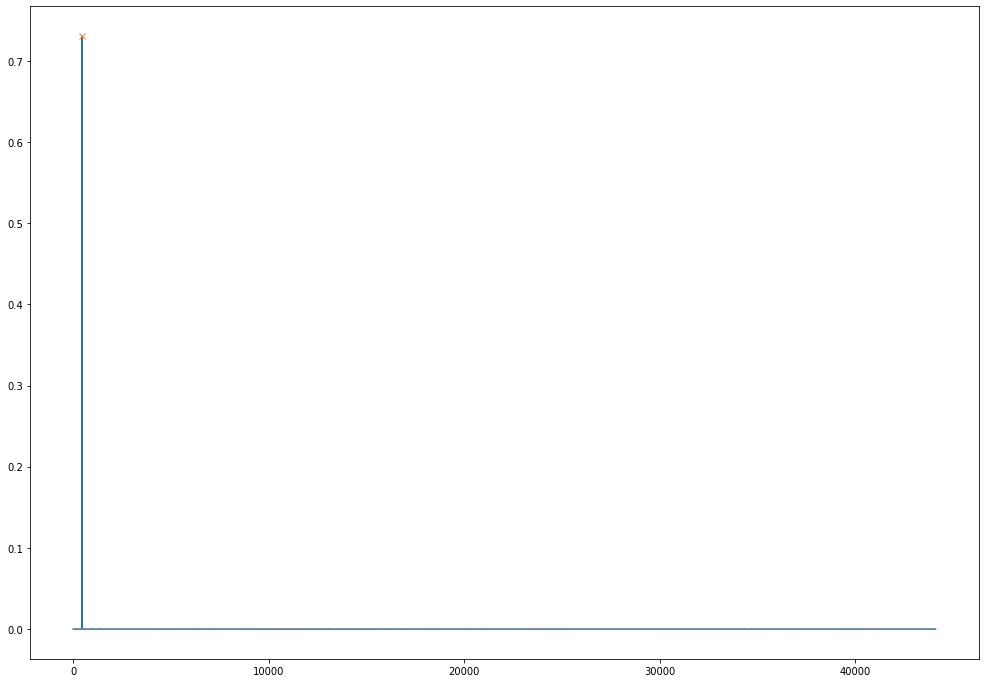

In [24]:
n_harmonics=1
batch_size=1
f0=220.
amp=0.6

n_frames = 500

harmonic_synth = Harmonic(44100*2, 44100)
sample_rate = harmonic_synth.sample_rate
controls = static_sawtooth_features(f0, amp, n_harmonics, n_frames, batch_size)
signal = harmonic_synth(**controls)
modified_controls = harmonic_synth.get_controls(**controls)

shit_mask = modified_controls['harmonic_distribution'][0, 0] > 0.
height = (modified_controls['harmonic_distribution'][:, :, shit_mask] * modified_controls[
    'amplitudes']).numpy().min() * 0.95
peak_freqs, peak_amps = get_batch_frequency_peaks(
    signal, sample_rate, height)

expected_peak_freqs = np.stack(batch_size * [np.arange(1, n_harmonics + 1) * f0])

dist_amps = modified_controls['harmonic_distribution'][:, 0, :]
base_amps = modified_controls['amplitudes'][:, 0, :]
expected_peak_amps = (dist_amps * base_amps).numpy()

# filter above nyquist
# TODO: currently we are assuming the whole batch has the same f0, harmonic, and amp values
#       otherwise peak_freqs and expected_peak_frames would have different sizes
#       later handle this by zero padding the smaller one or something like that
mask = expected_peak_freqs[0] < sample_rate / 2
expected_peak_amps = expected_peak_amps[:, mask]
expected_peak_freqs = expected_peak_freqs[:, mask]

np.testing.assert_array_almost_equal(peak_freqs, expected_peak_freqs, decimal=5)
np.testing.assert_array_almost_equal(peak_amps, expected_peak_amps, decimal=5)